## Web Scraping Ebay trending deals & items sell history analysis

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from imageio import imread
import html5lib
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_page(url):
    """Return soup object of url"""    
    response = requests.get(url)
    if not response.ok:
        print('Server responsed:', response.status_code)
    else:
        soup = BeautifulSoup(response.text, 'lxml')
    return soup

In [3]:
def get_title(epid):
    """"Return item title by epid(ebay product id)"""
    
    url =f'https://www.ebay.com/itm/{epid}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        title = soup.find('h1', class_='it-ttl').text.strip().split('  ')[1].strip()        
    except:
        title=''
    return title

In [4]:
def get_detail_data(soup, link):
    """Return dictionary of data extraced from soup object
       and 'epid' (ebay product id) extracted from link address
    """
    
    try:
        category = soup.find('span', itemprop='name').text.strip()       
    except:
        category=''        
    
    try:
        title = soup.find('h1', class_='it-ttl').text.strip().split('  ')[1].strip()       
    except:
        title=''
    
    try:
        price = soup.find('span', itemprop="price").text.strip().replace('$',"").replace(',',"")
        currency, price = price.split(' ')        
    except:
        currency =''
        price=''
        
    try:
        sold = soup.find('a', class_='vi-txt-underline').text.split()[0].replace(',',"")
    except:
        sold = ''
        
    epid = link.split('/')[5].split('?')[0]
        
        
    data = {
        'epid': epid,
        'category': category,
        'title': title,
        'price': price,
        'currency': currency,
        'sold': sold
    }    
    
    return data

In [5]:
def get_index_data(soup):
    """ Return list of urls from soup object"""
    
    try:
        links = soup.find_all('div',class_='dne-itemtile-detail')
    except:
        links=[]
        
    urls = [item.find('a')['href'] for item in links]
    
    return urls

In [6]:
def df_trending():
    """Return DataFrame of Ebay trending deals"""
    
    data_list = []
    url = 'https://www.ebay.com/deals/trending'
    products = get_index_data(get_page(url))
    for url in products:
        data = get_detail_data(get_page(url),url)
        data_list.append(data)
    df = pd.DataFrame(data_list)
    df = df.drop_duplicates(subset='epid', keep="first")
    df['price'] = pd.to_numeric(df['price'])
    df['sold'] = pd.to_numeric(df['sold'])
    df['total_money'] = df['price'] * df['sold']
    return df

In [7]:
def short_summary(df):
    "Return short summary of trending deal statistics"
    

    print(f'Numner of Items: {len(df)}')
    print(f'Item median price: ${df.price.median()}')
    print(f'Most expensive item: ${df[df.price == df.price.max()]["price"].item():,}  --> '\
          f'{df[df.price == df.price.max()]["title"].item()}')
    print(f'Most low priced item: ${df[df.price == df.price.min()]["price"].item()},  --> '\
          f'{df[df.price == df.price.min()]["title"].item()}')
    print(f'Best selling item by quantity: {df[df.sold == df.sold.max()]["sold"].item():,} units  --> '\
          f'{df[df.sold == df.sold.max()]["title"].item()}')
    print(f'Best selling item by total money: ${df[df.total_money == df.total_money.max()]["total_money"].item():,}  --> '\
          f'{df[df.total_money == df.total_money.max()]["title"].item()}')
    return

In [8]:
def group_plot(df):
    """Returns Bar Chart for groupby data"""
    
    df = df.groupby('category').agg(items=('price','count'),average_price=('price', 'mean'), units_sold=('sold', 'sum'),
                          total_money=('total_money','sum'))    
    for i in df.columns:
        df.sort_values(by= i, ascending=True, inplace=True)
        pie, ax = plt.subplots(figsize=[10,5])
        sns.barplot(x=i,y=df.index, data=df, palette='Spectral')
        plt.title(f"Category by {i}", fontsize=14); plt.ylabel("");


In [9]:
def image_scrape(epid):
    """"Return the main image of the item"""
    
    url =f'https://www.ebay.com/itm/{epid}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    a = soup.find('img', itemprop="image")
    image = imread(a['src'])
    return image

In [10]:
def sale_history_data(epid):
    """"Get epid(ebay product id) and Return preprocessed DataFrame of item last 100 transactions"""
        
    df = pd.read_html(f'https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item={epid}&rt=nc&_trksid=p2047675.l2564',\
                            match='Date of Purchase')[1][['Price','Quantity','Date of Purchase']][:100]
    df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
    df.set_index('Date of Purchase', inplace=True)
    df.sort_index(inplace=True)
    df.index = df.index.tz_localize('US/Pacific').tz_convert('EST').tz_localize(None)
    df.insert(1,'Currency',df.Price.map(lambda x:x.split()[0]))
    df['Price'] = df['Price'].str.replace('Sold as a special offer',"0 00")
    df['Price'] = df['Price'].str.replace(',','').map(lambda x: x.split()[1][1:]).astype(float)
    df['Quantity'] = pd.to_numeric(df['Quantity'])
    df.replace(0.00,df.median(axis=0),inplace=True)
    df.name = epid
    return df

In [11]:
def sale_history_plot(sale_h, resample='hourly'):
    """"Return sale history price vs quantity plot with a background of the main image for the item"""

    resampler = {'daily':'D','hourly':'H'}
    agg = sale_h.resample(resampler[resample]).agg({'Price':'last', 'Quantity':'sum'}).ffill()
    fig, ax = plt.subplots(figsize = (12, 5))
    width = 0.05 if resampler[resample] == 'H' else 0.9
    plt.bar(agg.index, agg.Quantity, width=width, edgecolor='navy');
    ax2 = ax.twinx()
    ax2.plot(agg.index,agg.Price, color='r', lw=5, alpha=0.7);
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m- %H'))
    ax.set_ylabel('Quantity', fontsize=16, color='blue', size=20, rotation=360, labelpad=50);
    ax2.set_ylabel('Price', fontsize=16, color='r', size=20, rotation=360, labelpad=50);
    ax2.set_yticklabels(['${:.0f}'.format(x) for x in ax2.get_yticks()])
    ax2.tick_params(axis='y', color='r', labelsize=10);
    plt.yticks(color='r', size=11);
    ax.tick_params(axis='y', color='blue', labelsize=11);
    plt.yticks(color='r', size=11);
    plt.title(f'Item {sale_h.name} sale history \n ({get_title(sale_h.name)})');
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    plt.imshow(image_scrape(sale_h.name), zorder=0,extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=0.4);
    

In [12]:
# Get DataFrame of all Ebay current trending deals
df = df_trending()
df.head()

,epid,category,title,price,currency,sold,total_money
0,164263907308,Consumer Electronics,"Bose Home Speaker 450, Certified Refurbished",179.95,US,1438.0,258768.10
1,124014973844,Video Games & Consoles,Sony PlayStation PS Plus 12-Month / 1 Year Mem...,31.50,US,103324.0,3254706.00
2,154197495779,Computers/Tablets & Networking,"Lenovo ThinkPad X1 Yoga Gen 4 Laptop, 14.0"" FH...",929.99,US,106.0,98578.94
3,274121616607,Health & Beauty,Dyson Supersonic Hair Dryer | Refurbished,219.99,US,13381.0,2943686.19
4,372752746415,Jewelry & Watches,"Ring Pad - 5-Pack Velvet Ring Display Tray, Ri...",12.99,US,32.0,415.68


In [13]:
short_summary(df)

Numner of Items: 130
Item median price: $52.99
Most expensive item: $71,342.94  --> Blancpain Le Brassus Platinum One Minute Flying Carrousel Men's Watch
Most low priced item: $5.0,  --> Essential Oils 10 mL - 100% Pure and Natural - Free Shipping - US Seller!
Best selling item by quantity: 173,231.0 units  --> Egyptian Comfort 1800 Count 4 Piece Bed Sheet Set Deep Pocket Bed Sheets
Best selling item by total money: $6,215,414.71  --> Apple iPhone XR 64GB Factory Unlocked Smartphone 4G LTE iOS Smartphone


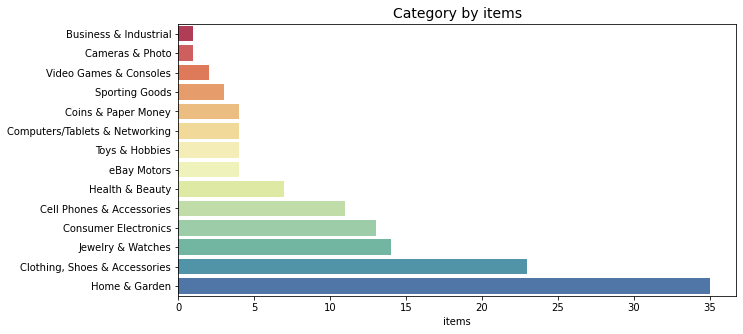

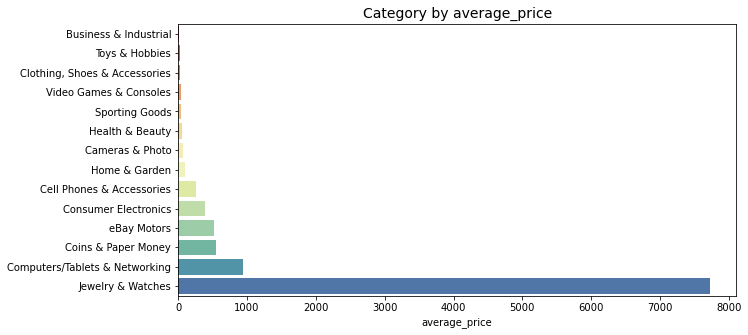

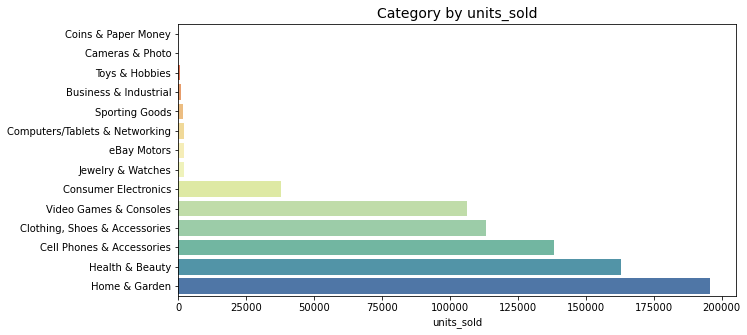

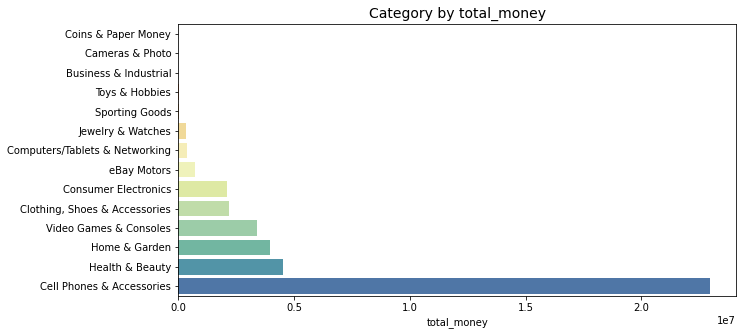

In [14]:
# Plot statistics for tredning deals by category
group_plot(df)

In [15]:
# Get sell history by item number(epid) 
sale_h = sale_history_data('324316649688')
sale_h.head()

,Price,Currency,Quantity
Date of Purchase,,,
2020-10-17 18:23:28,59.99,US,1
2020-10-18 16:38:43,59.99,US,1
2020-10-19 07:29:04,59.99,US,1
2020-10-19 13:00:18,59.99,US,1
2020-10-20 16:25:26,59.99,US,1


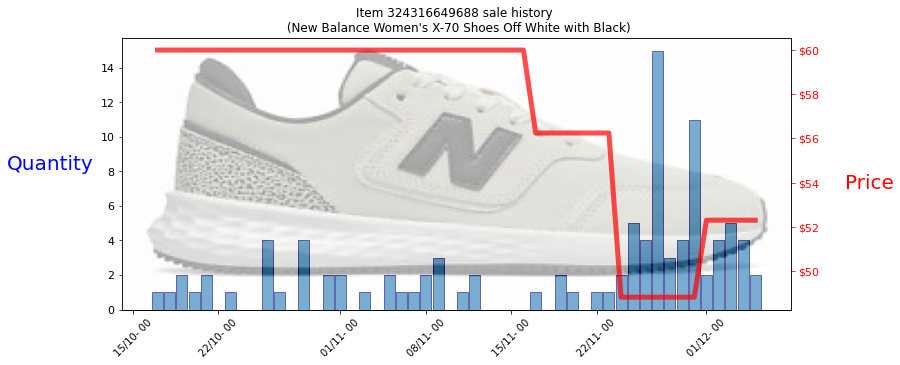

In [16]:
# Plot of price vs. quantity up to the last 100 transactions
sale_history_plot(sale_h,'daily')